In [1]:
!pip install scikeras

In [2]:
!pip install tensorflow-addons

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, History
from scikeras.wrappers import KerasClassifier
from google.colab import drive
import time
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.backend as K
# import tensorflow_addons as tfa
import tensorflow as tf
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
test_size = 0.9
epochs = 100
batch_size = 32
learning_rate = 0.0001
validation_split = 0.1
patience = 10

top_features_drop = 'no' # yes or no
if top_features_drop == 'yes':
    top_features_count = 38 # yes
else:
    top_features_count = 10 # no

undersampling = 'no'
slicetype1, slicetype2 = 'eMBB','mMTC' # eMBB, mMTC, URLLC

model_arch = 'complex' # simple or complex
if model_arch == 'complex':
    first_layer_neurons = 256 # complex
else:
    first_layer_neurons = 64 # simple

selected_features_count = 10

# start_index = 35
# end_index = start_index + 10

In [5]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    f1 = 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))
    return f1

# metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tfa.metrics.F1Score(num_classes=3, average='macro')]
metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]

In [6]:
def build_model(input_dim, output_units):
  if model_arch == 'complex':
      print("\n Building complex model")
      model = Sequential()
      model.add(Dense(first_layer_neurons, input_dim=input_dim, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(128, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(64, activation='relu'))
      # model.add(Dropout(0.2))

      model.add(Dense(32, activation='relu'))
      # model.add(Dropout(dropout_rate))

      model.add(Dense(16, activation='relu'))
      # model.add(Dropout(dropout_rate))

      model.add(Dense(output_units, activation='softmax'))  # Final output layer
      return model

  if model_arch == 'simple':
      print("\n Building simple model")
      model = Sequential()
      model.add(Dense(first_layer_neurons, input_dim=input_dim, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(32, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(16, activation='relu'))
      # model.add(Dropout(0.2))

      model.add(Dense(output_units, activation='softmax'))  # Final output layer
      return model

# **Class Imbalance**

In [7]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_preprocessed.csv')
data

,X,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,State,SrcWin,DstWin,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat,UniqueID,SliceType
0,34555.0000,982.000000,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,4,224,...,1,64128.000,64256.00000,3904203819,3.704605e+09,0.000000,0.000000,0.000000,144379.000,URLLC
1,531568.0000,11362.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,...,4,1270506.667,63695.85949,1836252122,2.446250e+09,0.000000,0.000000,0.000000,181691.000,URLLC
2,360399.0000,70834.000000,2.560251,2.560251,2.560251,2.560251,2.560251,2.560251,4,0,...,5,1270506.667,63695.85949,1836252122,2.446250e+09,0.000000,0.000000,0.000000,175580.000,URLLC
3,30702.0000,440.000000,0.046014,0.046014,0.046014,0.046014,0.046014,0.046014,4,0,...,1,56960.000,77568.00000,97975463,3.508802e+09,0.000000,0.000000,0.000000,120239.000,URLLC
4,312747.0000,128397.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,...,4,1270506.667,63695.85949,1836252122,2.446250e+09,0.000000,0.000000,0.000000,348612.000,URLLC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,455292.3772,281.829734,3.620188,3.961441,3.642492,4.080528,3.689328,3.684907,3,0,...,1,64256.000,64896.00000,1202036791,1.485176e+08,0.595314,0.723920,0.032170,2373584.832,mMTC
14452,455262.0258,298.318232,4.376486,2.966175,3.594366,3.873222,3.280655,3.083385,3,0,...,1,64256.000,64896.00000,1202036791,1.485176e+08,0.652207,0.874332,0.028468,2367298.319,mMTC
14453,455286.2470,293.324452,3.818366,3.667252,4.340313,4.514485,3.882577,4.103266,3,0,...,1,64256.000,64896.00000,1202036791,1.485176e+08,0.876566,0.250007,0.041358,2383580.426,mMTC
14454,455211.1026,171.202752,4.414447,4.101491,4.156414,4.301263,4.173065,4.550792,3,0,...,1,64256.000,64896.00000,1202036791,1.485176e+08,0.547553,0.645027,0.027258,2384145.715,mMTC


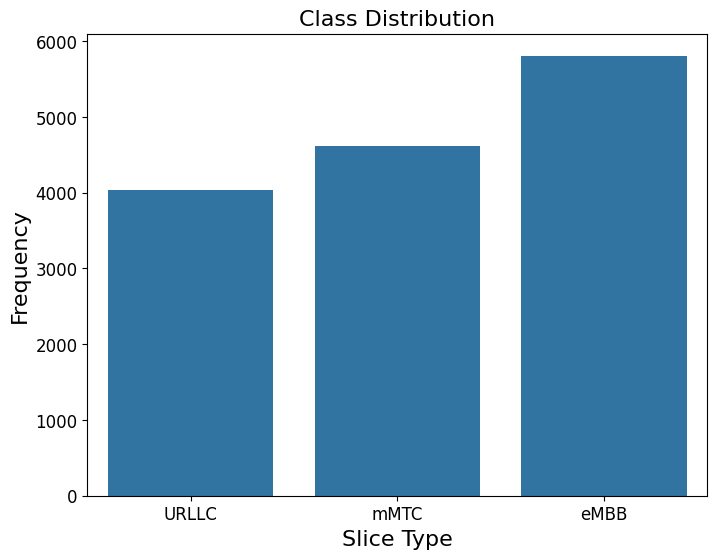

In [8]:
df = data.copy()

# Class Distribution Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='SliceType', data=df)
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Slice Type', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

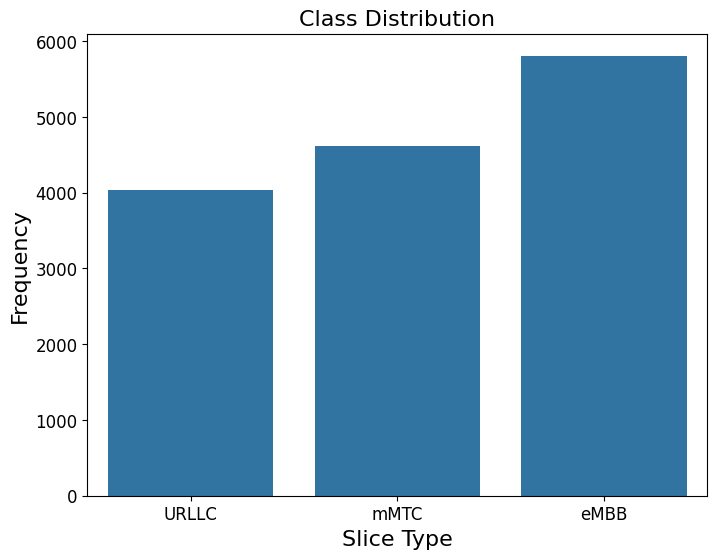

In [9]:
if undersampling == 'yes':
  print("\n Performing undersampling")
  if slicetype1:
    print(f"\n Removing {slicetype1}")
    # Fetch label indices
    indices = df[df['SliceType'] == slicetype1].index

    # The number of rows to remove
    num_rows_to_remove = int(len(indices) / 1.3)

    # Randomly select rows to remove
    rows_to_remove = np.random.choice(indices, size=num_rows_to_remove, replace=False)

    # Remove selected rows from the DataFrame
    df = df.drop(rows_to_remove)

  if slicetype2:
    print(f"\n Removing {slicetype2}")
    # Fetch label indices
    indices = df[df['SliceType'] == slicetype2].index

    # The number of rows to remove
    num_rows_to_remove = int(len(indices) / 1.3)

    # Randomly select rows to remove
    rows_to_remove = np.random.choice(indices, size=num_rows_to_remove, replace=False)

    # Remove selected rows from the DataFrame
    df = df.drop(rows_to_remove)

# Class Distribution Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='SliceType', data=df)
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Slice Type', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# **Top Features**

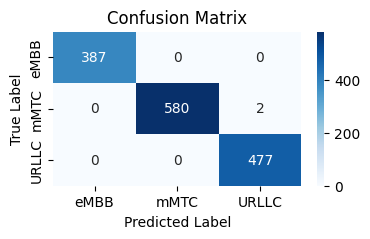

              precision    recall  f1-score   support

       URLLC     1.0000    1.0000    1.0000       387
        eMBB     1.0000    0.9966    0.9983       582
        mMTC     0.9958    1.0000    0.9979       477

    accuracy                         0.9986      1446
   macro avg     0.9986    0.9989    0.9987      1446
weighted avg     0.9986    0.9986    0.9986      1446



In [10]:
X = df.drop('SliceType', axis=1)
y = df['SliceType']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
# y_pred

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['eMBB', 'mMTC', 'URLLC'], yticklabels=['eMBB', 'mMTC', 'URLLC'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, digits=4))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

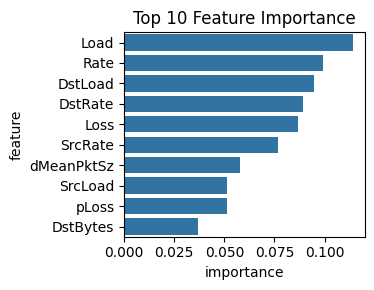


Top 10 Important Features:
       feature  importance
27        Load    0.114295
36        Rate    0.099063
29     DstLoad    0.094709
38     DstRate    0.089017
30        Loss    0.086671
37     SrcRate    0.076782
26  dMeanPktSz    0.057677
28     SrcLoad    0.051399
33       pLoss    0.051338
23    DstBytes    0.036644


In [11]:
# Plot feature importance
plt.figure(figsize=(4,3))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

## Drop features

In [12]:
X.head()

,X,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,DstRate,State,SrcWin,DstWin,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat,UniqueID
0,34555.0,982.0,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,4,224,...,0.000000,1,64128.000,64256.00000,3904203819,3.704605e+09,0.0,0.0,0.0,144379.0
1,531568.0,11362.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,...,0.000000,4,1270506.667,63695.85949,1836252122,2.446250e+09,0.0,0.0,0.0,181691.0
2,360399.0,70834.0,2.560251,2.560251,2.560251,2.560251,2.560251,2.560251,4,0,...,0.000000,5,1270506.667,63695.85949,1836252122,2.446250e+09,0.0,0.0,0.0,175580.0
3,30702.0,440.0,0.046014,0.046014,0.046014,0.046014,0.046014,0.046014,4,0,...,43.465034,1,56960.000,77568.00000,97975463,3.508802e+09,0.0,0.0,0.0,120239.0
4,312747.0,128397.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,...,0.000000,4,1270506.667,63695.85949,1836252122,2.446250e+09,0.0,0.0,0.0,348612.0


In [13]:
top_features = feature_importance['feature'].head(top_features_count).tolist()
# top_features = feature_importance['feature'][start_index:end_index].tolist()
print(top_features)

['Load', 'Rate', 'DstLoad', 'DstRate', 'Loss', 'SrcRate', 'dMeanPktSz', 'SrcLoad', 'pLoss', 'DstBytes']


In [14]:
if top_features_drop == 'yes':
  print("\n Dropping top features")
  X = X.drop(top_features, axis=1)
else:
  print("\n Selecting top features")
  X = X[top_features]
X.head()


 Selecting top features


,Load,Rate,DstLoad,DstRate,Loss,SrcRate,dMeanPktSz,SrcLoad,pLoss,DstBytes
0,0.000000,3460.207764,0.00000,0.000000,0.0,0.000000,60.000000,0.000000,0.0,60.0
1,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,131.237137,0.390587,0.00000,0.000000,0.0,0.390587,0.000000,131.237137,0.0,0.0
3,84843.742190,108.662582,23297.25781,43.465034,0.0,43.465034,66.666664,61546.484380,0.0,200.0
4,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [15]:
if top_features_drop == 'yes':
  # Removing 80% of the data
  X_temp, X_drop, y_temp, y_drop = train_test_split(X, y, test_size=test_size, random_state=42)

  # Split the 20% of the data
  X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=validation_split, random_state=42)

  # Train a Random Forest model
  rf_model_no_top_features = RandomForestClassifier(n_estimators=100, random_state=42)
  start_time_rfc = time.time()
  rf_model_no_top_features.fit(X_train, y_train)
  end_time_rfc = time.time()
  latency_rfc = end_time_rfc - start_time_rfc
  print(f"\n Training Latency RFC: {latency_rfc} seconds")

  # Make predictions
  y_pred = rf_model_no_top_features.predict(X_test)
  # y_pred

  # Print confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(4,2))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['eMBB', 'mMTC', 'URLLC'], yticklabels=['eMBB', 'mMTC', 'URLLC'])
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

  # Print classification report
  print(classification_report(y_test, y_pred, digits=4))

In [16]:

# # Feature importance
# feature_importance = pd.DataFrame({
#     'feature': X.columns,
#     'importance': rf_model_no_top_features.feature_importances_
# }).sort_values('importance', ascending=False)

# # Plot feature importance
# plt.figure(figsize=(8,6))
# sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
# plt.title('Top 10 Feature Importance')
# plt.tight_layout()
# plt.show()

# print("\nTop 10 Important Features:")
# print(feature_importance.head(10))

In [17]:
df_selected_features = X.copy()

# Resetting indices to avoid alignment issues
df_selected_features.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

df_selected_features['SliceType'] = y
df_selected_features

,Load,Rate,DstLoad,DstRate,Loss,SrcRate,dMeanPktSz,SrcLoad,pLoss,DstBytes,SliceType
0,0.000000,3460.207764,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,60.000000,URLLC
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,URLLC
2,131.237137,0.390587,0.000000,0.000000,0.000000,0.390587,0.000000,131.237137,0.000000,0.000000,URLLC
3,84843.742190,108.662582,23297.257810,43.465034,0.000000,43.465034,66.666664,61546.484380,0.000000,200.000000,URLLC
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,URLLC
...,...,...,...,...,...,...,...,...,...,...,...
14451,2415.138241,3.821267,901.270514,1.594339,2.000000,2.019412,68.162787,1613.406298,10.105935,478.546229,mMTC
14452,2471.046868,3.722216,763.222253,1.400239,1.257694,2.029394,67.734197,1553.066132,9.210293,417.788733,mMTC
14453,2283.097961,3.840632,855.459521,1.626468,2.000000,2.037339,68.009158,1774.842835,10.360201,520.916319,mMTC
14454,2106.446226,3.244096,699.197109,1.408035,1.609694,1.797084,67.815812,1354.903131,7.659634,484.317812,mMTC


In [18]:
df_selected_features.to_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_selected_features.csv', index=False)

# **Data Perturbation**

In [19]:
X = df_selected_features.drop('SliceType', axis=1)
y = df_selected_features['SliceType']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Train a Random Forest model
RFC_Model = RandomForestClassifier(n_estimators=100, random_state=42)
RFC_Model.fit(X_train, y_train)
X_test

,Load,Rate,DstLoad,DstRate,Loss,SrcRate,dMeanPktSz,SrcLoad,pLoss,DstBytes
3146,1.477076e+02,0.439606,0.000000e+00,0.000000,0.000000,0.439606,0.000000,147.707626,0.000000,0.000000
14090,2.263857e+03,3.632123,7.849698e+02,1.463701,1.000000,1.928375,67.055171,1466.519430,5.716374,500.613081
13473,2.541616e+03,3.721983,7.653655e+02,1.422970,1.000000,1.994199,67.135955,1484.382602,5.400960,488.598364
14074,2.171078e+03,3.556572,7.381477e+02,1.359428,1.000000,1.739120,67.467081,1413.843126,6.086617,454.095091
13012,4.715410e+03,4.217047,3.911684e+03,2.809133,1.000000,2.193221,237.325137,1325.767343,8.913024,1269.535654
...,...,...,...,...,...,...,...,...,...,...
12312,9.824946e+03,12.753148,4.114158e+03,4.169645,15.797440,8.276388,122.707550,6287.713475,24.935564,2058.385067
12951,2.158169e+03,3.426367,6.242238e+02,1.477614,1.829089,1.726260,69.195689,1452.617210,7.440641,410.296222
1205,1.176018e+02,0.350005,0.000000e+00,0.000000,0.000000,0.350005,0.000000,117.601807,0.000000,0.000000
4971,1.719570e+06,251.886349,1.556884e+06,195.488300,1.000000,96.543884,1374.245846,86464.709460,0.245234,524175.773500


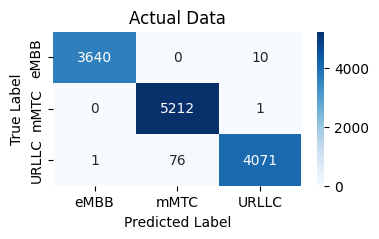

              precision    recall  f1-score   support

       URLLC     0.9997    0.9973    0.9985      3650
        eMBB     0.9856    0.9998    0.9927      5213
        mMTC     0.9973    0.9814    0.9893      4148

    accuracy                         0.9932     13011
   macro avg     0.9942    0.9928    0.9935     13011
weighted avg     0.9933    0.9932    0.9932     13011



In [20]:
# Make predictions
y_pred = RFC_Model.predict(X_test)

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['eMBB', 'mMTC', 'URLLC'], yticklabels=['eMBB', 'mMTC', 'URLLC'])
plt.title('Actual Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, digits=4))

In [21]:
# Create a copy to avoid modifying the original DataFrame
test_data_perturbed = X_test.copy()

# Resetting indices to avoid alignment issues
test_data_perturbed.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# y_pred.reset_index(drop=True, inplace=True)

actual_label = pd.Series(y_test, name='actual_label')

# Include the 'predicted labels' as a new column in the DataFrame
test_data_perturbed['actual_label'] = actual_label
test_data_perturbed

,Load,Rate,DstLoad,DstRate,Loss,SrcRate,dMeanPktSz,SrcLoad,pLoss,DstBytes,actual_label
0,1.477076e+02,0.439606,0.000000e+00,0.000000,0.000000,0.439606,0.000000,147.707626,0.000000,0.000000,URLLC
1,2.263857e+03,3.632123,7.849698e+02,1.463701,1.000000,1.928375,67.055171,1466.519430,5.716374,500.613081,mMTC
2,2.541616e+03,3.721983,7.653655e+02,1.422970,1.000000,1.994199,67.135955,1484.382602,5.400960,488.598364,mMTC
3,2.171078e+03,3.556572,7.381477e+02,1.359428,1.000000,1.739120,67.467081,1413.843126,6.086617,454.095091,mMTC
4,4.715410e+03,4.217047,3.911684e+03,2.809133,1.000000,2.193221,237.325137,1325.767343,8.913024,1269.535654,mMTC
...,...,...,...,...,...,...,...,...,...,...,...
13006,9.824946e+03,12.753148,4.114158e+03,4.169645,15.797440,8.276388,122.707550,6287.713475,24.935564,2058.385067,mMTC
13007,2.158169e+03,3.426367,6.242238e+02,1.477614,1.829089,1.726260,69.195689,1452.617210,7.440641,410.296222,mMTC
13008,1.176018e+02,0.350005,0.000000e+00,0.000000,0.000000,0.350005,0.000000,117.601807,0.000000,0.000000,URLLC
13009,1.719570e+06,251.886349,1.556884e+06,195.488300,1.000000,96.543884,1374.245846,86464.709460,0.245234,524175.773500,eMBB


In [22]:
# features= ['Load', 'Rate', 'DstLoad', 'DstRate', 'Loss', 'SrcRate', 'dMeanPktSz', 'SrcLoad', 'pLoss', 'DstBytes']
features= test_data_perturbed.select_dtypes(include=[np.number]).columns
selected_features = features[:selected_features_count]

test_data_perturbed[selected_features]
print("Selected Features:", selected_features.values, "\n")

Selected Features: ['Load' 'Rate' 'DstLoad' 'DstRate' 'Loss' 'SrcRate' 'dMeanPktSz' 'SrcLoad'
 'pLoss' 'DstBytes'] 



In [23]:
# Calculate the standard deviation for each numeric column
std_devs = test_data_perturbed[selected_features].std()

# Suggested noise scale as 10% of the standard deviation (you can adjust this factor)
noise_scale = std_devs * 0.1

# print(noise_scale)

# Add Gaussian noise to specific columns
for column in test_data_perturbed[selected_features].columns:
  noise = np.random.normal(0, noise_scale[column], test_data_perturbed[column].shape)
  test_data_perturbed[column] += noise

test_data_perturbed

,Load,Rate,DstLoad,DstRate,Loss,SrcRate,dMeanPktSz,SrcLoad,pLoss,DstBytes,actual_label
0,-3.228448e+06,1119.667671,2.918127e+03,181.335352,-0.168651,-157.798870,-70.211060,56662.680489,1.589839,-616.053459,URLLC
1,-6.091503e+06,547.882913,-2.780724e+06,-208.000198,1.464498,-503.096548,53.506596,161324.801098,6.542683,-3022.599831,mMTC
2,5.448318e+05,-1812.561239,-7.140921e+06,25.406152,1.367921,109.065619,189.401653,79522.504389,4.632380,1786.793395,mMTC
3,8.203769e+06,-1079.306971,-5.771601e+06,152.560988,0.874755,-238.175478,39.063326,28848.940194,5.555138,454.045088,mMTC
4,5.314324e+06,400.301679,-1.194728e+07,-192.149779,1.283885,238.633034,261.476503,-352368.352984,9.968860,-6709.056609,mMTC
...,...,...,...,...,...,...,...,...,...,...,...
13006,-6.358020e+06,1038.386761,2.662957e+06,-44.504965,16.019413,140.255846,121.812729,45597.238314,23.947999,2697.202140,mMTC
13007,-9.388518e+06,-0.180889,-2.856554e+06,-289.983931,1.698459,-215.588285,38.877107,71267.377417,6.784923,3252.313058,mMTC
13008,1.247668e+07,239.871279,-6.692716e+06,158.262328,-0.031194,136.305685,25.893713,-50319.069934,-0.336447,-6470.029504,URLLC
13009,4.279672e+06,-149.198224,1.362615e+07,56.154501,0.984384,-16.721294,1385.919041,-164277.956850,0.669465,522040.950372,eMBB


In [24]:
# Verification of Unaffected Columns - must return true
unchanged_columns = test_data_perturbed.drop(selected_features, axis=1)
print(unchanged_columns.equals(test_data_perturbed.drop(selected_features, axis=1)))

True


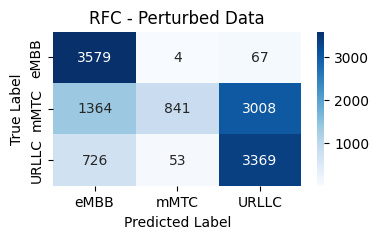

              precision    recall  f1-score   support

       URLLC     0.6313    0.9805    0.7681      3650
        eMBB     0.9365    0.1613    0.2752      5213
        mMTC     0.5228    0.8122    0.6361      4148

    accuracy                         0.5986     13011
   macro avg     0.6969    0.6514    0.5598     13011
weighted avg     0.7190    0.5986    0.5286     13011



In [25]:
X_test_perturbed = test_data_perturbed.drop('actual_label', axis=1)
y_test_perturbed = test_data_perturbed['actual_label']

# Make predictions
y_pred_on_perturbed = RFC_Model.predict(X_test_perturbed)

# Print confusion matrix
cm = confusion_matrix(y_test_perturbed, y_pred_on_perturbed)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['eMBB', 'mMTC', 'URLLC'], yticklabels=['eMBB', 'mMTC', 'URLLC'])
plt.title('RFC - Perturbed Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test_perturbed, y_pred_on_perturbed, digits=4))

# **5G Slice Ndd Dataset with Standalone Neural Network**

In [26]:
# Load the preprocessed dataset
# data3 = pd.read_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_preprocessed.csv')
data3 = pd.read_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_selected_features.csv')

# Separate features and target
X3 = data3.drop('SliceType', axis=1)
y3 = data3['SliceType']

# Drop top features if specified
if top_features_drop == 'yes':
  print("\n Dropping top features")
  X3 = X3.drop(top_features, axis=1)

# Encode target labels
le = LabelEncoder()
y3_encoded = le.fit_transform(y3)
y3 = to_categorical(y3_encoded)

# Scale features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the features
X3_scaled = scaler.fit_transform(X3)
# X3_scaled = X3

# Convert back to DataFrame for easier handling
X3 = pd.DataFrame(X3_scaled, columns=X3.columns)

# Split the data
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=test_size, random_state=42)

###############################################################################################################
# Build the neural network model
input_dim = X3.shape[1]
output_units = y3.shape[1]

model3 = build_model(input_dim, output_units)

###############################################################################################################

# Compile the model with custom metrics
# model3.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', recall, precision, f1_score])
model3.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=metrics)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Create a history object to store training metrics
history3 = History()

# Evaluate the model
loss3, accuracy3, recall3, precision3 = model3.evaluate(X3_test, y3_test)
print(f"Test Accuracy before training: {accuracy3:.4f} - Test Loss: {loss3:.4f} - Test Recall: {recall3:.4f} - Test Precision: {precision3:.4f}")

# start time
start_time_neural_network = time.time()

# Train the model with early stopping and history callbacks
model3.fit(X3_train, y3_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping, history3])

# end time
end_time_neural_network = time.time()

latency_neural_network = end_time_neural_network - start_time_neural_network
print(f"\n Standalone Neural Network --- Latency: {latency_neural_network} seconds - Training Accuracy: {history3.history['accuracy'][-1]:.4f} - Validation Accuracy: {history3.history['val_accuracy'][-1]:.4f} \n")

# Evaluate the model
loss3, accuracy3, recall3, precision3 = model3.evaluate(X3_test, y3_test)
print(f"Test Accuracy after training: {accuracy3:.4f} - Test Loss: {loss3:.4f} - Test Recall: {recall3:.4f} - Test Precision: {precision3:.4f}")


 Building complex model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


407/407 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0272 - loss: 1.2600 - precision: 0.0186 - recall: 2.9690e-04
Test Accuracy before training: 0.0283 - Test Loss: 1.2392 - Test Recall: 0.0008 - Test Precision: 0.0465
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2779 - loss: 1.1982 - precision: 0.1644 - recall: 0.0060 - val_accuracy: 0.8966 - val_loss: 1.0434 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6629 - loss: 1.0340 - precision: 0.7527 - recall: 0.0258 - val_accuracy: 0.9724 - val_loss: 0.9124 - val_precision: 1.0000 - val_recall: 0.1586
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8854 - loss: 0.9174 - precision: 0.9401 - recall: 0.1440 - val_accuracy: 0.9793 - val_loss: 0.7571 - val_precision: 1.0000 - val_recall: 0.3034
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9352 - loss: 0.7639 - precision: 0.9830 - recall: 0.2782 - val_accuracy: 0.

In [27]:
# Evaluate the model with Perturbed Data

# Encode target labels
y_test_perturbed_encoded = le.fit_transform(y_test_perturbed)
y_test_perturbed = to_categorical(y_test_perturbed_encoded)

# Fit and transform the features
X_test_perturbed_scaled = scaler.fit_transform(X_test_perturbed)

# Convert back to DataFrame for easier handling
X_test_perturbed = pd.DataFrame(X_test_perturbed_scaled, columns=X_test_perturbed.columns)

# Get the predicted output from the model
y3_pred_on_perturbed = model3.predict(X_test_perturbed)

loss3, accuracy3, recall3, precision3 = model3.evaluate(X_test_perturbed, y_test_perturbed)
print(f"Perturbed Data - Test Accuracy: {accuracy3:.4f} - Test Loss: {loss3:.4f} - Test Recall: {recall3:.4f} - Test Precision: {precision3:.4f}")

407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6979 - loss: 2.5684 - precision: 0.6999 - recall: 0.6956
Perturbed Data - Test Accuracy: 0.6983 - Test Loss: 2.5740 - Test Recall: 0.6957 - Test Precision: 0.6998


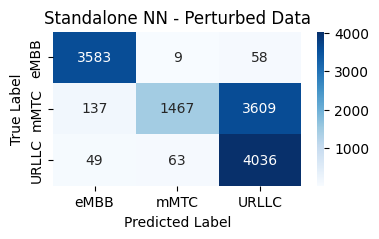

              precision    recall  f1-score   support

       URLLC     0.9507    0.9816    0.9659      3650
        eMBB     0.9532    0.2814    0.4345      5213
        mMTC     0.5240    0.9730    0.6811      4148

    accuracy                         0.6983     13011
   macro avg     0.8093    0.7454    0.6939     13011
weighted avg     0.8156    0.6983    0.6622     13011



In [28]:
# Convert the one-hot encoded output to class labels
y_test_perturbed_decoded = np.argmax(y_test_perturbed, axis=1)
y3_pred_on_perturbed_decoded = np.argmax(y3_pred_on_perturbed, axis=1)

# Decode the predicted class labels back to original class names
y_test_perturbed = le.inverse_transform(y_test_perturbed_decoded)
y3_pred_on_perturbed = le.inverse_transform(y3_pred_on_perturbed_decoded)

# Print confusion matrix
cm = confusion_matrix(y_test_perturbed, y3_pred_on_perturbed)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['eMBB', 'mMTC', 'URLLC'], yticklabels=['eMBB', 'mMTC', 'URLLC'])
plt.title('Standalone NN - Perturbed Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test_perturbed, y3_pred_on_perturbed, digits=4))

In [29]:
# # Retrieve metrics from the history object
# train_acc3 = history3.history['accuracy']
# val_acc3 = history3.history['val_accuracy']

# train_loss3 = history3.history['loss']
# val_loss3 = history3.history['val_loss']

# train_precision3 = history3.history['precision']
# val_precision3 = history3.history['val_precision']

# train_recall3 = history3.history['recall']
# val_recall3 = history3.history['val_recall']

# # train_f13 = history3.history['f1_score']
# # val_f13 = history3.history['val_f1_score']

# # Print metrics for each epoch
# # for epoch in range(len(train_acc3)):
# #     print(f"Epoch {epoch+1}:")
# #     print(f"  Training Accuracy: {train_acc3[epoch]:.4f}, Validation Accuracy: {val_acc3[epoch]:.4f}")
# #     print(f"  Training Loss: {train_loss3[epoch]:.4f}, Validation Loss: {val_loss3[epoch]:.4f}")
# #     print(f"  Training Precision: {train_precision3[epoch]:.4f}, Validation Precision: {val_precision3[epoch]:.4f}")
# #     print(f"  Training Recall: {train_recall3[epoch]:.4f}, Validation Recall: {val_recall3[epoch]:.4f}")
# #     print(f"  Training F1 Score: {train_f13[epoch]:.4f}, Validation F1 Score: {val_f13[epoch]:.4f}")


# # Plot accuracy and loss over epochs
# plt.figure(figsize=(20, 5))
# plt.suptitle('Standalone Neural Network')

# plt.subplot(1, 5, 1)
# plt.plot(train_acc3, label='Training Accuracy')
# plt.plot(val_acc3, label='Validation Accuracy')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 5, 2)
# plt.plot(train_loss3, label='Training Loss')
# plt.plot(val_loss3, label='Validation Loss')
# plt.title('Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 5, 3)
# plt.plot(train_precision3, label='Training Precision')
# plt.plot(val_precision3, label='Validation Precision')
# plt.title('Precision over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.legend()

# plt.subplot(1, 5, 4)
# plt.plot(train_recall3, label='Training Recall')
# plt.plot(val_recall3, label='Validation Recall')
# plt.title('Recall over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.legend()

# # plt.subplot(1, 5, 5)
# # plt.plot(train_f13, label='Training F1 Score')
# # plt.plot(val_f13, label='Validation F1 Score')
# # plt.title('F1 Score over Epochs')
# # plt.xlabel('Epochs')
# # plt.ylabel('F1 Score')
# # plt.legend()

# plt.tight_layout()
# plt.show()

In [30]:
# # Predict on the test set
# y_pred3 = model3.predict(X3_test)

# # Convert predictions to class labels
# y_pred3_class = np.argmax(y_pred3, axis=1)
# y_test_class = np.argmax(y3_test, axis=1)

# # Calculate precision, recall, and F1 score
# precision = precision_score(y_test_class, y_pred3_class, average='macro')
# recall = recall_score(y_test_class, y_pred3_class, average='macro')
# f1 = f1_score(y_test_class, y_pred3_class, average='macro')

# # Calculate confusion matrix
# conf_mat = confusion_matrix(y_test_class, y_pred3_class)

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print("Confusion Matrix:")
# print(conf_mat)

# **Base Model using Neural Network on DeepSlice Dataset**

In [31]:
# Load deepslice_data.csv
data1 = pd.read_csv('/content/drive/MyDrive/Dataset/deepslice_data.csv.zip')

# Data pre-processing
# Feature Conversion - Categorical to Numerical
one_hot_encoded_data1 = pd.get_dummies(data1, columns = ['Day','Use Case', 'Technology Supported', 'GBR'])
data1_ohe = one_hot_encoded_data1.rename(columns={'Day_sunday':'sunday','Day_monday':'monday','Day_tuesday':'tuesday','Day_wednesday':'wednesday','Day_thrusday':'thrusday','Day_friday':'friday','Day_saturday':'saturday','Use Case_AR/VR/Gaming':'AR/VR/Gaming','Use Case_Healthcare':'Healthcare','Use Case_Industry 4.0':'Industry 4.0','Use Case_IoT Devices':'IoT Devices','Use Case_Public Safety':'Public Safety','Use Case_Smart City & Home':'Smart City & Home','Use Case_Smart Transportation':'Smart Transportation','Use Case_Smartphone':'Smartphone','Technology Supported_IoT(LTE-M, NB-IoT)':'IoT','Technology Supported_LTE/5G':'LTE/5G','GBR_GBR':'GBR','GBR_Non-GBR':'Non-GBR'})
data1 = data1_ohe[['LTE/5g Category', 'Time', 'sunday', 'monday', 'tuesday', 'wednesday', 'thrusday', 'friday', 'saturday', 'Packet Loss Rate', 'Packet delay', 'IoT',	'LTE/5G',	'GBR',	'Non-GBR', 'AR/VR/Gaming',	'Healthcare',	'Industry 4.0', 'IoT Devices',	'Public Safety',	'Smart City & Home',	'Smart Transportation',	'Smartphone', 'slice Type']]

# Replace boolean values with 0 and 1 in specified columns
columns_to_convert = ['sunday', 'monday', 'tuesday', 'wednesday', 'thrusday', 'friday', 'saturday', "IoT", "LTE/5G", "GBR", "Non-GBR", "AR/VR/Gaming", "Healthcare", "Industry 4.0", "IoT Devices", "Public Safety", "Smart City & Home", "Smart Transportation", "Smartphone"]
for column in columns_to_convert:
    data1[column] = data1[column].replace({False: 0, True: 1})

data1 = data1.drop_duplicates()

X1 = data1.drop('slice Type', axis=1)
y1 = data1['slice Type']

# Encode target labels if necessary
le = LabelEncoder()
y1_encoded = le.fit_transform(y1)

# Scale features
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# Split data into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1_encoded, test_size=0.2, random_state=42)

##################################################################################################
# Create a new model with input layer
input_dim_X1 = X1_scaled.shape[1]
output_units_y1 = len(np.unique(y1_encoded))

# Build the model for X1_scaled and y1_encoded
model1 = build_model(input_dim=input_dim_X1, output_units=output_units_y1)

#################################################################################################

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create a history object to store training metrics
history1 = History()

# start time
start_time_base_model1_training = time.time()

# Train the model on new data
model1.fit(X1_train, y1_train, epochs=10, batch_size=32, validation_split=0.5, callbacks=[early_stopping, history1])

# end time
end_time_base_model1_training = time.time()

latency_base_model1_training = end_time_base_model1_training - start_time_base_model1_training
print(f"\n Latency for base model1 training: {latency_base_model1_training} seconds")

# Evaluate on test set
loss1, accuracy1 = model1.evaluate(X1_test, y1_test)
print(f"Test Accuracy: {accuracy1:.4f}")

# Save the trained model if needed
model1.save('deep_slice_model.h5')

<ipython-input-31-a078db5d0f8a>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data1[column] = data1[column].replace({False: 0, True: 1})
<ipython-input-31-a078db5d0f8a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[column] = data1[column].replace({False: 0, True: 1})



 Building complex model
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5391 - loss: 1.0387 - val_accuracy: 0.9897 - val_loss: 0.7363
Epoch 2/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9697 - loss: 0.6408 - val_accuracy: 1.0000 - val_loss: 0.2334
Epoch 3/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9970 - loss: 0.2075 - val_accuracy: 1.0000 - val_loss: 0.0554
Epoch 4/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9987 - loss: 0.0627 - val_accuracy: 1.0000 - val_loss: 0.0167
Epoch 5/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9998 - loss: 0.0234 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 6/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 7/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 8/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 1.0000 - val_

Test Accuracy: 1.0000


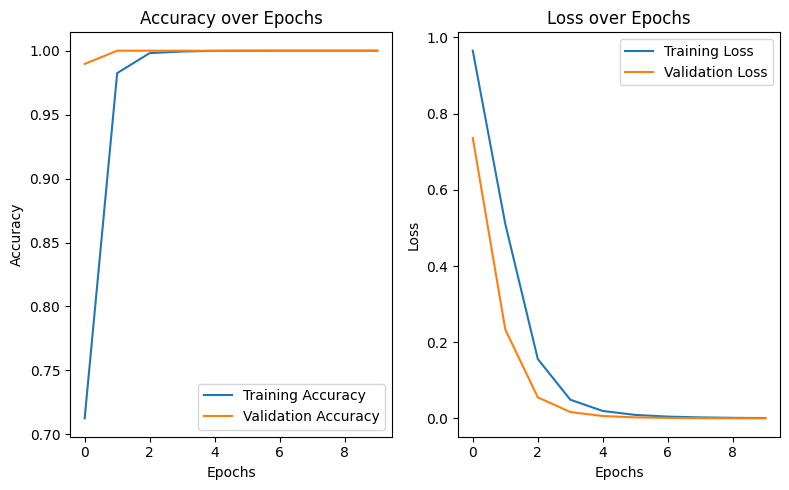

In [32]:
# Retrieve metrics from the history object
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Print metrics for each epoch
# for epoch in range(len(train_acc)):
#     print(f"Epoch {epoch+1}:")
#     print(f"  Training Accuracy: {train_acc[epoch]:.4f}, Validation Accuracy: {val_acc[epoch]:.4f}")
#     print(f"  Training Loss: {train_loss[epoch]:.4f}, Validation Loss: {val_loss[epoch]:.4f}")

# Plot accuracy and loss over epochs
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Transfer Learning on 5G Slice Ndd Dataset**

In [33]:
# Load deepslice_data.csv
# data2 = pd.read_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_preprocessed.csv')
data2 = pd.read_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_selected_features.csv')

# Data pre-processing
# Separate features and target
X2 = data2.drop('SliceType', axis=1)
y2 = data2['SliceType']

# Drop top features if specified
if top_features_drop == 'yes':
  print("\n Dropping top features")
  X2 = X2.drop(top_features, axis=1)

# Encode target labels
le = LabelEncoder()
y2_encoded = le.fit_transform(y2)
y2 = to_categorical(y2_encoded)

# Scale features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the features
X2_scaled = scaler.fit_transform(X2)
X2_scaled = X2

# Convert back to DataFrame for easier handling
X2 = pd.DataFrame(X2_scaled, columns=X2.columns)

# Split the data
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = X3_train, X3_test, y3_train, y3_test

##################################################################################################
# Load pre-trained model
model1 = load_model('deep_slice_model.h5')

# Freeze layers if needed
# for layer in model_pt.layers[:-2]:  # Freeze all but last layer
#     layer.trainable = False

# Create a new model with adjusted input layer
model2 = Sequential()

# Add a new input layer with the correct shape
model2.add(Dense(first_layer_neurons, activation='relu', input_shape=(X2_train.shape[1],)))

# Add layers from the pre-trained model (excluding the input layer)
for layer in model1.layers[1:]:
    model2.add(layer)

#################################################################################################

# Compile the model
model2.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=metrics)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Create a history object to store training metrics
history2 = History()

# Evaluate on test set
loss2, accuracy2, recall2, precision2 = model2.evaluate(X2_test, y2_test)
print(f"Test Accuracy Before Training: {accuracy2:.4f}")

# start time
start_time_transfer_learning = time.time()

for epoch in range(int(epochs*1.5)):
  # Train the model on new data
  print(f"\n Epoch: {epoch+1}")
  model2.fit(X2_train, y2_train, epochs=1, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping, history2])

  # end time
  end_time_transfer_learning = time.time()

  latency_transfer_learning = end_time_transfer_learning - start_time_transfer_learning

  print("\n latency_transfer_learning:", latency_transfer_learning, "\t latency_neural_network:", latency_neural_network, "\n")

  # should_stop_training = latency_transfer_learning >= latency_neural_network
  # if should_stop_training:
  #   print("\n Training stopped as latency limit is reached")
  #   break

print(f"\n Transfer Learning --- Latency: {latency_transfer_learning} seconds - Training Accuracy: {history2.history['accuracy'][-1]:.4f} - Validation Accuracy: {history2.history['val_accuracy'][-1]:.4f} \n")
print(f"\n Standalone Neural Network --- Latency: {latency_neural_network} seconds - Training Accuracy: {history3.history['accuracy'][-1]:.4f} - Validation Accuracy: {history3.history['val_accuracy'][-1]:.4f} \n")

# Evaluate on test set
loss2, accuracy2, recall2, precision2 = model2.evaluate(X2_test, y2_test)
print(f"Test Accuracy After Training: {accuracy2:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2568 - loss: 14.0469 - precision: 0.6261 - recall: 0.5510
Test Accuracy Before Training: 0.2525

 Epoch: 1
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4743 - loss: 1.3083 - precision: 0.5515 - recall: 0.3737 - val_accuracy: 0.9517 - val_loss: 0.3920 - val_precision: 0.9758 - val_recall: 0.8345

 latency_transfer_learning: 2.9639511108398438 	 latency_neural_network: 40.08952736854553 


 Epoch: 2
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8728 - loss: 0.6722 - precision: 0.9137 - recall: 0.7495 - val_accuracy: 0.9793 - val_loss: 0.2575 - val_precision: 0.9783 - val_recall: 0.9310

 latency_transfer_learning: 3.339613199234009 	 latency_neural_network: 40.08952736854553 


 Epoch: 3
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9335 - loss: 0.4520 - precision: 0.9541 - recall: 0.8637 - val_accuracy: 0.9793 - val_loss: 0.2061 - val_precision: 0.9786 - val_recall: 0.9448

 latency_transfer_learning: 3.7546784

In [34]:
# Evaluate the model with Perturbed Data

# Encode target labels
y_test_perturbed_encoded = le.fit_transform(y_test_perturbed)
y_test_perturbed = to_categorical(y_test_perturbed_encoded)

# Fit and transform the features
X_test_perturbed_scaled = scaler.fit_transform(X_test_perturbed)

# Convert back to DataFrame for easier handling
X_test_perturbed = pd.DataFrame(X_test_perturbed_scaled, columns=X_test_perturbed.columns)

# Get the predicted output from the model
y2_pred_on_perturbed = model2.predict(X_test_perturbed)

loss2, accuracy2, recall2, precision2 = model2.evaluate(X_test_perturbed, y_test_perturbed)
print(f"Perturbed Data - Test Accuracy: {accuracy2:.4f} - Test Loss: {loss2:.4f} - Test Recall: {recall2:.4f} - Test Precision: {precision2:.4f}")

407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6838 - loss: 2.9685 - precision: 0.6864 - recall: 0.6815
Perturbed Data - Test Accuracy: 0.6843 - Test Loss: 2.9758 - Test Recall: 0.6817 - Test Precision: 0.6866


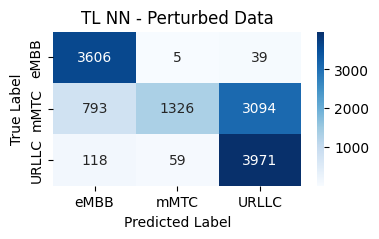

              precision    recall  f1-score   support

       URLLC     0.7983    0.9879    0.8831      3650
        eMBB     0.9540    0.2544    0.4016      5213
        mMTC     0.5590    0.9573    0.7058      4148

    accuracy                         0.6843     13011
   macro avg     0.7704    0.7332    0.6635     13011
weighted avg     0.7844    0.6843    0.6337     13011



In [35]:
# Convert the one-hot encoded output to class labels
y_test_perturbed_decoded = np.argmax(y_test_perturbed, axis=1)
y2_pred_on_perturbed_decoded = np.argmax(y2_pred_on_perturbed, axis=1)

# Decode the predicted class labels back to original class names
y_test_perturbed = le.inverse_transform(y_test_perturbed_decoded)
y2_pred_on_perturbed = le.inverse_transform(y2_pred_on_perturbed_decoded)

# Print confusion matrix
cm = confusion_matrix(y_test_perturbed, y2_pred_on_perturbed)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['eMBB', 'mMTC', 'URLLC'], yticklabels=['eMBB', 'mMTC', 'URLLC'])
plt.title('TL NN - Perturbed Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test_perturbed, y2_pred_on_perturbed, digits=4))

In [36]:
# # Retrieve metrics from the history object
# train_acc2 = history2.history['accuracy']
# val_acc2 = history2.history['val_accuracy']

# train_loss2 = history2.history['loss']
# val_loss2 = history2.history['val_loss']

# train_precision2 = history2.history['precision']
# val_precision2 = history2.history['val_precision']

# train_recall2 = history2.history['recall']
# val_recall2 = history2.history['val_recall']

# # train_f12 = history2.history['f1_score']
# # val_f12 = history2.history['val_f1_score']

# # Print metrics for each epoch
# # for epoch in range(len(train_acc2)):
# #     print(f"Epoch {epoch+1}:")
# #     print(f"  Training Accuracy: {train_acc2[epoch]:.4f}, Validation Accuracy: {val_acc2[epoch]:.4f}")
# #     print(f"  Training Loss: {train_loss2[epoch]:.4f}, Validation Loss: {val_loss2[epoch]:.4f}")
# #     print(f"  Training Precision: {train_precision2[epoch]:.4f}, Validation Precision: {val_precision2[epoch]:.4f}")
# #     print(f"  Training Recall: {train_recall2[epoch]:.4f}, Validation Recall: {val_recall2[epoch]:.4f}")
# #     print(f"  Training F1 Score: {train_f12[epoch]:.4f}, Validation F1 Score: {val_f12[epoch]:.4f}")


# # Plot accuracy and loss over epochs
# plt.figure(figsize=(20, 5))
# plt.suptitle('Transfer Learning')

# plt.subplot(1, 5, 1)
# plt.plot(train_acc2, label='Training Accuracy')
# plt.plot(val_acc2, label='Validation Accuracy')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 5, 2)
# plt.plot(train_loss2, label='Training Loss')
# plt.plot(val_loss2, label='Validation Loss')
# plt.title('Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 5, 3)
# plt.plot(train_precision2, label='Training Precision')
# plt.plot(val_precision2, label='Validation Precision')
# plt.title('Precision over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.legend()

# plt.subplot(1, 5, 4)
# plt.plot(train_recall2, label='Training Recall')
# plt.plot(val_recall2, label='Validation Recall')
# plt.title('Recall over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.legend()

# # plt.subplot(1, 5, 5)
# # plt.plot(train_f12, label='Training F1 Score')
# # plt.plot(val_f12, label='Validation F1 Score')
# # plt.title('F1 Score over Epochs')
# # plt.xlabel('Epochs')
# # plt.ylabel('F1 Score')
# # plt.legend()

# plt.tight_layout()
# plt.show()

# **SYNC NOTEBOOKS**

In [37]:
%cp '/content/drive/MyDrive/Colab Notebooks/Exp19_NSI_TL_vs_RFC_data_perturbation.ipynb' '/content/drive/MyDrive/Network_Slicing_with_ML_repo/Network-Slicing-with-ML/Notebooks/'